# COVID-19 ANALYSIS

This is an analysis of the COVID-19 pandemic in South Africa from March to August 2020

# Load libraries

In [1]:
from scipy.integrate import odeint
from datetime import datetime, date

import numpy as np
import pandas as pd
import seaborn as sns
from ggplot import *
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\zintl\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\zintl\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\zintl\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\zintl\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\zintl\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
#national_report = pd.read_csv('../data/nicd_daily_national_report.csv')
confirmed = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')
transmission = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_transmission_type.csv')
hospitals = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/health_system_za_hospitals_v1.csv')

In [3]:
confirmed['date'] = pd.to_datetime(confirmed['date'], format='%d-%m-%Y')
confirmed.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
172,2020-08-26,20200826,85472.0,35980.0,207610.0,111096.0,12795.0,23555.0,9500.0,24646.0,104997.0,50.0,615701,https://twitter.com/nicd_sa/status/12987029468...
173,2020-08-27,20200827,85625.0,36419.0,208156.0,111585.0,12867.0,23677.0,9829.0,24805.0,105273.0,50.0,618286,https://twitter.com/nicd_sa/status/12990610006...
174,2020-08-28,20200828,85701.0,36742.0,208579.0,111863.0,12960.0,23765.0,10043.0,24922.0,105507.0,50.0,620123,https://twitter.com/nicd_sa/status/12994458373...


In [4]:
recoveries['date'] = pd.to_datetime(recoveries['date'], format='%d-%m-%Y')
recoveries.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
125,2020-08-26,20200826,80614,22740,176513,93814,11580,21370,6409,17702,94500,0,525242,https://twitter.com/nicd_sa/status/12987029468...
126,2020-08-27,20200827,81373,22829,178479,94680,11639,21591,6640,17993,96114,0,531338,https://twitter.com/nicd_sa/status/12990610006...
127,2020-08-28,20200828,81373,23031,179631,95011,11832,21994,6784,18165,96114,0,533935,https://twitter.com/nicd_sa/status/12994458373...


In [5]:
deaths['date'] = pd.to_datetime(deaths['date'], format='%d-%m-%Y')
deaths.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
148,2020-08-26,20200826,2828,567,3395,2054,179,312,120,224,3823,0,13502,https://twitter.com/nicd_sa/status/12987029468...
149,2020-08-27,20200827,2853,567,3428,2102,179,312,120,224,3843,0,13628,https://twitter.com/nicd_sa/status/12990610006...
150,2020-08-28,20200828,2863,567,3475,2116,179,330,120,240,3853,0,13743,https://twitter.com/nicd_sa/status/12994458373...


In [ ]:
transmission = transmission.drop(['Unnamed: 4'], axis = 1)
transmission.head(2)

Create a new dataframe with the total number of confirmed positive cases, recoveries and deaths.

In [88]:
# combine the number of cases into a new dataframe
total_cases = pd.concat([confirmed['date'], confirmed['total'],
                         recoveries['total'], deaths['total']], axis=1)

In [89]:
total_cases['confirmed'] = confirmed['total']
total_cases['recoveries'] = recoveries['total']
total_cases['deaths'] = deaths['total']

# convert date column from string to datetime
total_cases['date'] = pd.to_datetime(total_cases['date'], format='%d-%m-%Y')

In [90]:
# drop the repeated columns
total_cases = total_cases.drop(['total', 'total', 'total'], axis=1)

In [91]:
total_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        175 non-null    datetime64[ns]
 1   confirmed   175 non-null    int64         
 2   recoveries  128 non-null    float64       
 3   deaths      151 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.6 KB


In [92]:
# shift rows down so that dates correspond
total_cases['recoveries'] = total_cases['recoveries'].shift(47)
total_cases['deaths'] = total_cases['deaths'].shift(24)

In [93]:
# fill NAs with zeros
total_cases['recoveries'] = total_cases['recoveries'].fillna(0)
total_cases['deaths'] = total_cases['deaths'].fillna(0)

In [94]:
# calculate recovery and deaths rates
total_cases['recov_rate'] = (total_cases['recoveries']/total_cases['confirmed'])*100
total_cases['death_rate'] = (total_cases['deaths']/total_cases['confirmed'])*100

In [97]:
# create a month column
total_cases['month'] = total_cases['date'].dt.month

# change month number to month name
total_cases['month'] = total_cases['month'].replace(3, 'March')
total_cases['month'] = total_cases['month'].replace(4, 'April')
total_cases['month'] = total_cases['month'].replace(5, 'May')
total_cases['month'] = total_cases['month'].replace(6, 'June')
total_cases['month'] = total_cases['month'].replace(7, 'July')
total_cases['month'] = total_cases['month'].replace(8, 'August')

In [98]:
total_cases.head()

,date,confirmed,recoveries,deaths,recov_rate,death_rate,month
0,2020-03-05,1,0.0,0.0,0.0,0.0,March
1,2020-03-07,2,0.0,0.0,0.0,0.0,March
2,2020-03-08,3,0.0,0.0,0.0,0.0,March
3,2020-03-09,7,0.0,0.0,0.0,0.0,March
4,2020-03-11,13,0.0,0.0,0.0,0.0,March


Recoveries were recorded only 47 days after the first positive case was confirmed, and deaths were first reported after 24 days. To date there are 525 242 recoveries and 13 502 deaths. 

## Confirmed cases, recoveries and deaths

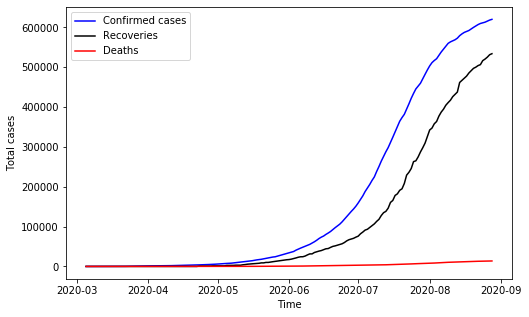

In [166]:
# plot the number of positive cases and recoveries
plt.figure(figsize=(8, 5))

plt.plot(total_cases['date'], total_cases['confirmed'],
         color='blue', label='Confirmed cases')
plt.plot(total_cases['date'], total_cases['recoveries'],
         color='black', label='Recoveries')
plt.plot(total_cases['date'], total_cases['deaths'],
         color='red', label='Deaths')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Total cases')
plt.xlabel('Time')

plt.show()

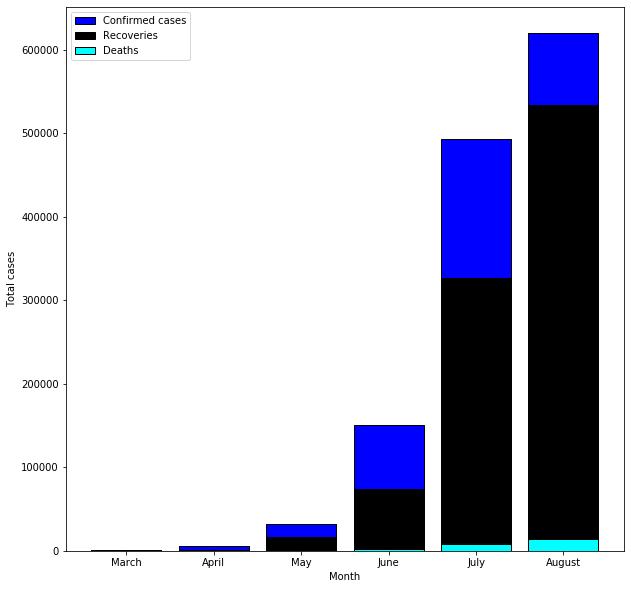

In [60]:
# set figure size
plt.figure(figsize=(10, 10))

# plot all cases in a bar graph
plt.bar(total_cases['month'], total_cases['confirmed'],
        color='blue', edgecolor='black', label='Confirmed cases')
plt.bar(total_cases['month'], total_cases['recoveries'],
        color='black', edgecolor='black', label='Recoveries')
plt.bar(total_cases['month'], total_cases['deaths'],
        color='cyan', edgecolor='black', label='Deaths')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Total cases')
plt.xlabel('Month')

plt.show()

More positive cases were reported from June to July. There has been a positive increase in recoveries and a small proportion of confirmed cases resulted in death.

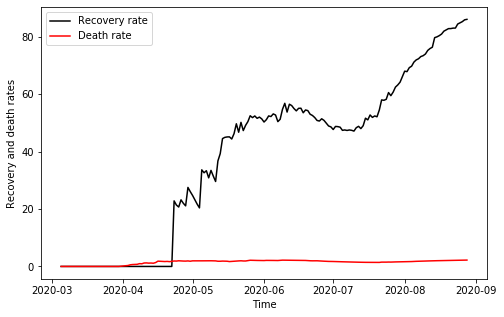

In [165]:
plt.figure(figsize=(8, 5))

plt.plot(total_cases['date'], total_cases['recov_rate'],
         color='black', label='Recovery rate')
plt.plot(total_cases['date'], total_cases['death_rate'],
         color='red', label='Death rate')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Recovery and death rates')
plt.xlabel('Time')

plt.show()

Even with the exponential increase in confirmed cases the death rate has been minimal, with only 2.2% of COVID related deaths being reported to date.

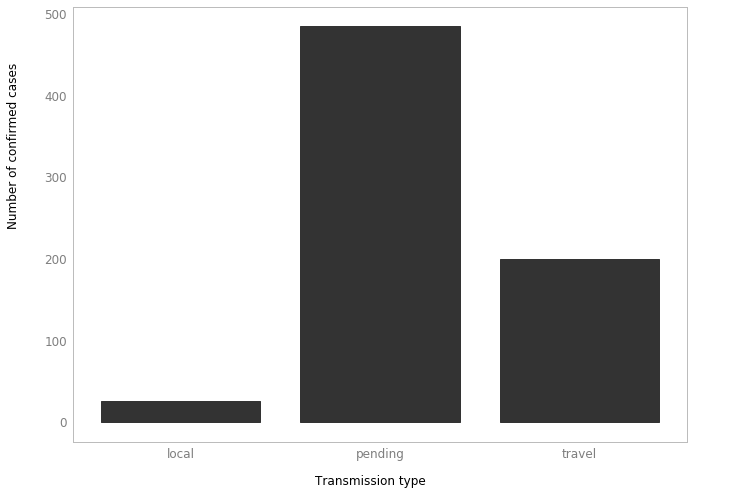

<ggplot: (-9223371867199433142)>

In [74]:
# plot the number of cases based on transmission type
ggplot(transmission, aes(x = 'type')) + \
    xlab('Transmission type') + \
    ylab('Number of confirmed cases') + \
    geom_bar() + \
    theme_bw() + \
    theme()

An analysis of cases reported in mid-March (25 March 2020) showed that more people who tested positive for the virus had travelled abroad and contracted the virus in that period. This was before the travel ban was implemented. 

## Cases by province

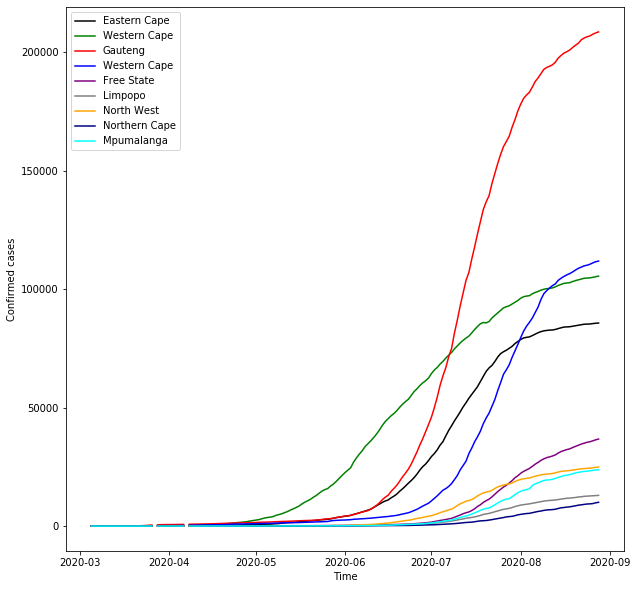

In [171]:
plt.figure(figsize=(10,10))

plt.plot(confirmed['date'], confirmed['EC'],
         color='black', label='Eastern Cape')
plt.plot(confirmed['date'], confirmed['WC'],
         color='green', label='Western Cape')
plt.plot(confirmed['date'], confirmed['GP'],
         color='red', label='Gauteng')
plt.plot(confirmed['date'], confirmed['KZN'],
         color='blue', label='Western Cape')
plt.plot(confirmed['date'], confirmed['FS'],
         color='purple', label='Free State')
plt.plot(confirmed['date'], confirmed['LP'],
         color='grey', label='Limpopo')
plt.plot(confirmed['date'], confirmed['NW'],
         color='orange', label='North West')
plt.plot(confirmed['date'], confirmed['NC'],
         color='navy', label='Northern Cape')
plt.plot(confirmed['date'], confirmed['MP'],
         color='cyan', label='Mpumalanga')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Confirmed cases')
plt.xlabel('Time')

plt.show()

Gauteng, KZN, the Eastern Cape and the Western Cape have the highest positive cases in the country.

# SIR Modelling

In order to model how the virus will spread we need to use the SIR model which requires the number of susceptible individuals, those who have been infected and those who have recovered. Two epidemiological quantities are also needed: the infection rate and the recovery rate. The reproductive rate of the virus when the first case was reported was 2.07. At the moment the model does not account for lockdown and travel restrictions.
The code for this model was obtained from scipython.com.

In [140]:
# total population
N = 59431006

# recoveries & active infections
I0 = 1
R0 = 0

# susceptible
S0 = N - I0 - R0

# infection rate
B = 2.07

# recovery rate
G = 1/14

# set the number of days to 250
t = range(0, 250)

In [141]:
# SIR model differential equations
def derivative(y, t, N, B, G):
    S, I, R = y
    dSdt = -B * S * I / N
    dIdt = B * S * I / N - G * I
    dRdt = G * I
    return dSdt, dIdt, dRdt

In [142]:
# initial conditions
y0 = S0, I0, R0
ret = odeint(derivative, y0, t, args=(N, B, G))
S, I, R = ret.T

# create a dataframe for S, I and R
infection_model = pd.DataFrame(
    {'susceptible': S,
     'infected': I,
     'recovered': R,
     'days': t})

In [133]:
infection_model.tail()

,susceptible,infected,recovered,days
245,0.000015,2.835992,5.943100e+07,245
246,0.000015,2.640486,5.943100e+07,246
247,0.000015,2.458459,5.943100e+07,247
248,0.000015,2.288979,5.943100e+07,248
249,0.000015,2.131183,5.943100e+07,249


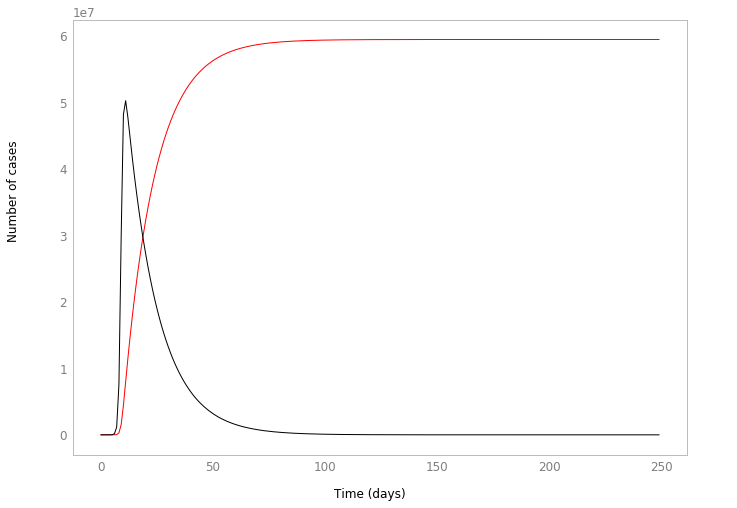

<ggplot: (-9223371877550148629)>

In [143]:
ggplot(infection_model, aes(x='days')) + \
    geom_line(aes(y='recovered'), color='red') + \
    geom_line(aes(y='infected'), color='black') + \
    xlab('Time (days)') + \
    ylab('Number of cases') + \
    theme_bw() + \
    theme()